# Transformer-based Recommendation System 

## References

1.   This experiment is based on the tutorial ["A Transformer-based recommendation system"](https://keras.io/examples/structured_data/movielens_recommendations_transformers/) by Khalid Salama;
2.   The Movielens dataset (1 Mio) is available at this [link](https://grouplens.org/datasets/movielens/1m/);
3.   Concept of Behavior Sequence Transformer (BTS) is described in the research paper ["Behavior Sequence Transformer for E-commerce Recommendation in Alibaba"](https://arxiv.org/abs/1905.06874) by Qiwei Chen, Huan Zhao, Wei Li, Pipei Huang, Wenwu Ou ;



## Setup

In [3]:
import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup

## Dataset

The dataset includes around 1 million ratings from 6000 users on 4000 movies,
along with some user features, movie genres. In addition, the timestamp of each user-movie rating is provided, which allows creating sequences of movie ratings for each user, as expected by the BST model.

### Ratings File Description
All ratings are contained in the file "ratings.dat" and are in the following format:

UserID::MovieID::Rating::Timestamp

*   UserIDs range between 1 and 6040
*   MovieIDs range between 1 and 3952
*   Ratings are made on a 5-star scale (whole-star ratings only)
*   Timestamp is represented in seconds since the epoch as returned by time(2)
*   Each user has at least 20 ratings

### Users File Description

User information is in the file "users.dat" and is in the following
format:

UserID::Gender::Age::Occupation::Zip-code

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

### Movies File Description
Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the different genres, like Action, Animation, Comedy, etc.

###Note: 
Check README file in the extracted folder for more information on the dataset.


In [ ]:
# downloading the dataset:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()

In [4]:
# The downloaded folder will contain three data files: users.dat, movies.dat, and ratings.dat.
# loading the data into pandas DataFrames:
users = pd.read_csv(
    "ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
)

ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
)

movies = pd.read_csv(
    "ml-1m/movies.dat", sep="::", names=["movie_id", "title", "genres"]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


In [5]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [7]:
users.head()

,user_id,sex,age_group,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   sex         6040 non-null   object
 2   age_group   6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip_code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [9]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   user_id         1000209 non-null  int64
 1   movie_id        1000209 non-null  int64
 2   rating          1000209 non-null  int64
 3   unix_timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [11]:
# fixing data types in the users dataframe columns:
users["user_id"] = users["user_id"].apply(lambda x: f"user_{x}")
users["age_group"] = users["age_group"].apply(lambda x: f"group_{x}")
users["occupation"] = users["occupation"].apply(lambda x: f"occupation_{x}")

In [12]:
# fixing data types in the movies dataframe columns:
movies["movie_id"] = movies["movie_id"].apply(lambda x: f"movie_{x}")

In [13]:
# fixing data types in the ratings dataframe columns:
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: f"movie_{x}")
ratings["user_id"] = ratings["user_id"].apply(lambda x: f"user_{x}")
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [14]:
# Each movie has multiple genres. We split them into separate columns in the `movies` DataFrame.
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

for genre in genres:
    movies[genre] = movies["genres"].apply(
        lambda values: int(genre in values.split("|"))
    )

In [15]:
movies.head()

,movie_id,title,genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,movie_1,Toy Story (1995),Animation|Children's|Comedy,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,movie_2,Jumanji (1995),Adventure|Children's|Fantasy,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,movie_3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,movie_4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,movie_5,Father of the Bride Part II (1995),Comedy,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Introducing Behavior Sequence Transformer (BST)

[Qiwei Chen et al.](https://arxiv.org/abs/1905.06874) implemented BST in their recommendation system, which resulted in Click-Through-Rate (CTR) outperforming results. 

Previous experiments in the area of recommendation systems (RS) were mainly based on the embedding raw features into low-dimensional vectors as input to MLP, which in turn provided final recommendations.  Those projects didn't take into consideration user behavior sequence, which the authors consider as crucial to improve prediction power of recommendation systems.

The authors suggest using Transformer from machine translation task in NLP, which could catch words dependency in sentences (and also users' behavior sequences) by using self-attention mechanism.  

Recommendation systems in Alibaba have two-steps pipeline: match (finding similar candidate items based on user's selected items) and rank (predicting probability of a user to click on candidate items).

The focus of this research paper is on ranking side, which is built on top of the wide and deep learning (WDL) network from Google.  They define recommendation task as CTR prediction problem, where user's behavior is described as a sequence of items.  Based on this sequence, the task is to define function to predict probability of clicking by a user on target item.

The architecture of the model is presented below.  

*   User behavior sequence, target item and other features (like user profile features, context features, item features, cross features) are embedded into low-dimensional vectors fed as input to the model.
*  Transformer layer is used to learn relations in the user behavior sequence.
*  Other features embedding is concatenated into transformer layer output.
*  Followed up by 3 MLPs and sigmoid function to generate final predictions.



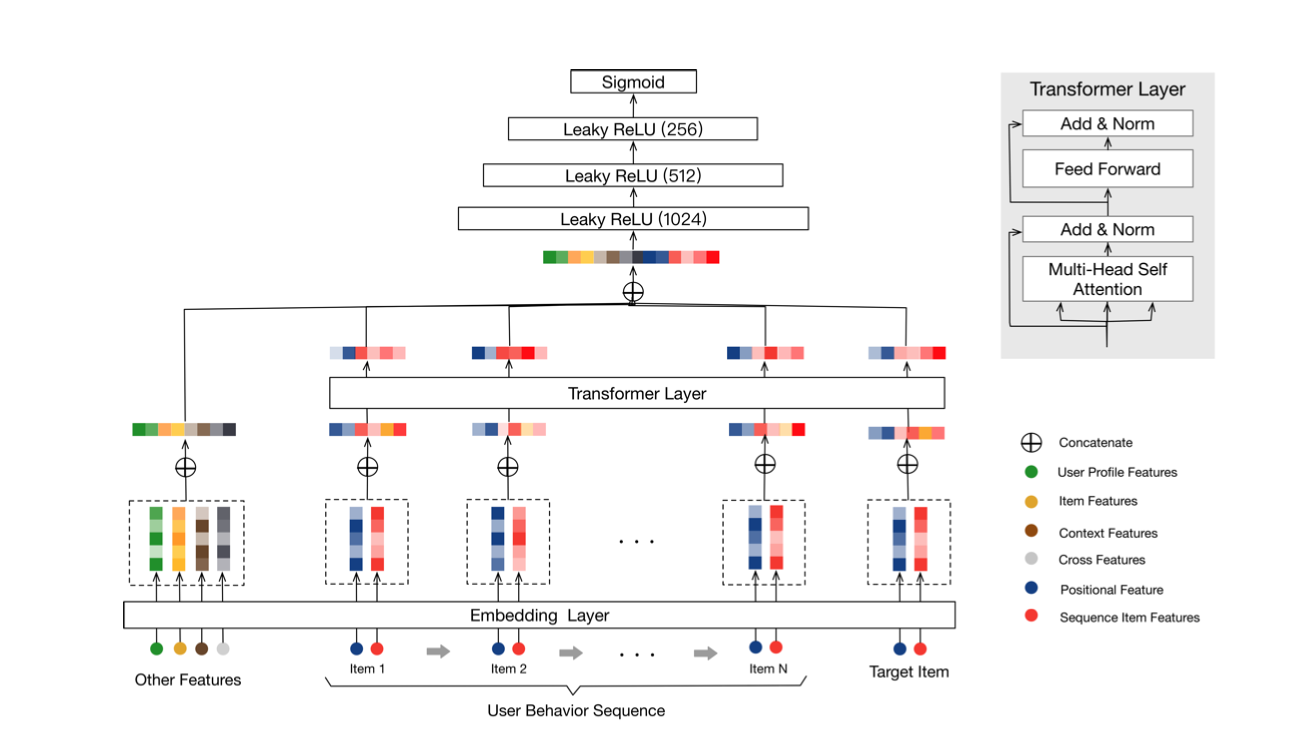

In [16]:
from IPython.display import Image
Image('BST_Architecture.png')

## Integrating BST into current recommendation system

In the present RS, BST model is used to predict the rating of a target movie by a user with the following inputs into the model:

1. A fixed-length *sequence* of `movie_ids` watched by a user.
2. A fixed-length *sequence* of the `ratings` for the movies watched by a user.
3. A *set* of user features, including `user_id`, `sex`, `occupation`, and `age_group`.
4. A *set* of `genres` for each movie in the input sequence and the target movie.
5. A `target_movie_id` for which to predict the rating.

This example modifies the original BST model in the following ways:

1. We incorporate the movie features (genres) into the processing of the embedding of each
movie of the input sequence and the target movie, rather than treating them as "other features"
outside the transformer layer.
2. We utilize the ratings of movies in the input sequence, along with the their positions
in the sequence, to update them before feeding them into the self-attention layer.


Note that this example should be run with TensorFlow 2.4 or higher.

## Transform the movie ratings data into sequences

First, let's sort the the ratings data using the `unix_timestamp`, and then group the
`movie_id` values and the `rating` values by `user_id`.

The output DataFrame will have a record for each `user_id`, with two ordered lists
(sorted by rating datetime): the movies they have rated, and their ratings of these movies.

In [17]:
ratings_group = ratings.sort_values(by=["unix_timestamp"]).groupby("user_id")

ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "movie_ids": list(ratings_group.movie_id.apply(list)),
        "ratings": list(ratings_group.rating.apply(list)),
        "timestamps": list(ratings_group.unix_timestamp.apply(list)),
    }
)


In [18]:
ratings_data.head()

,user_id,movie_ids,ratings,timestamps
0,user_1,"[movie_3186, movie_1721, movie_1270, movie_102...","[4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 4.0, 5.0, ...","[978300019, 978300055, 978300055, 978300055, 9..."
1,user_10,"[movie_597, movie_858, movie_743, movie_1210, ...","[4.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 3.0, ...","[978224375, 978224375, 978224375, 978224400, 9..."
2,user_100,"[movie_260, movie_1676, movie_1198, movie_541,...","[4.0, 3.0, 4.0, 3.0, 4.0, 3.0, 1.0, 1.0, 5.0, ...","[977593595, 977593595, 977593607, 977593624, 9..."
3,user_1000,"[movie_971, movie_260, movie_2990, movie_2973,...","[4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 2.0, 5.0, 5.0, ...","[975040566, 975040566, 975040566, 975040629, 9..."
4,user_1001,"[movie_1198, movie_1617, movie_2885, movie_390...","[4.0, 4.0, 4.0, 2.0, 2.0, 1.0, 4.0, 5.0, 5.0, ...","[975039591, 975039702, 975039702, 975039898, 9..."


Now, let's split the `movie_ids` list into a set of sequences of a fixed length.
We do the same for the `ratings`. Set the `sequence_length` variable to change the length
of the input sequence to the model. You can also change the `step_size` to control the
number of sequences to generate for each user.

In [19]:
sequence_length = 4
step_size = 2


def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences


ratings_data.movie_ids = ratings_data.movie_ids.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

ratings_data.ratings = ratings_data.ratings.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

del ratings_data["timestamps"]

In [20]:
ratings_data.head()

,user_id,movie_ids,ratings
0,user_1,"[[movie_3186, movie_1721, movie_1270, movie_10...","[[4.0, 4.0, 5.0, 5.0], [5.0, 5.0, 3.0, 5.0], [..."
1,user_10,"[[movie_597, movie_858, movie_743, movie_1210]...","[[4.0, 3.0, 3.0, 4.0], [3.0, 4.0, 4.0, 5.0], [..."
2,user_100,"[[movie_260, movie_1676, movie_1198, movie_541...","[[4.0, 3.0, 4.0, 3.0], [4.0, 3.0, 4.0, 3.0], [..."
3,user_1000,"[[movie_971, movie_260, movie_2990, movie_2973...","[[4.0, 5.0, 4.0, 3.0], [4.0, 3.0, 5.0, 5.0], [..."
4,user_1001,"[[movie_1198, movie_1617, movie_2885, movie_39...","[[4.0, 4.0, 4.0, 2.0], [4.0, 2.0, 2.0, 1.0], [..."


After that, we process the output to have each sequence in a separate records in
the DataFrame. In addition, we join the user features with the ratings data.

In [21]:
ratings_data_movies = ratings_data[["user_id", "movie_ids"]].explode(
    "movie_ids", ignore_index=True
)
ratings_data_rating = ratings_data[["ratings"]].explode("ratings", ignore_index=True)
ratings_data_transformed = pd.concat([ratings_data_movies, ratings_data_rating], axis=1)
ratings_data_transformed = ratings_data_transformed.join(
    users.set_index("user_id"), on="user_id"
)
ratings_data_transformed.movie_ids = ratings_data_transformed.movie_ids.apply(
    lambda x: ",".join(x)
)
ratings_data_transformed.ratings = ratings_data_transformed.ratings.apply(
    lambda x: ",".join([str(v) for v in x])
)

del ratings_data_transformed["zip_code"]

ratings_data_transformed.rename(
    columns={"movie_ids": "sequence_movie_ids", "ratings": "sequence_ratings"},
    inplace=True,
)

In [22]:
ratings_data_transformed.head()

,user_id,sequence_movie_ids,sequence_ratings,sex,age_group,occupation
0,user_1,"movie_3186,movie_1721,movie_1270,movie_1022","4.0,4.0,5.0,5.0",F,group_1,occupation_10
1,user_1,"movie_1270,movie_1022,movie_2340,movie_1836","5.0,5.0,3.0,5.0",F,group_1,occupation_10
2,user_1,"movie_2340,movie_1836,movie_3408,movie_1207","3.0,5.0,4.0,4.0",F,group_1,occupation_10
3,user_1,"movie_3408,movie_1207,movie_2804,movie_260","4.0,4.0,5.0,4.0",F,group_1,occupation_10
4,user_1,"movie_2804,movie_260,movie_720,movie_1193","5.0,4.0,3.0,5.0",F,group_1,occupation_10


With `sequence_length` of 4 and `step_size` of 2, we end up with 498,623 sequences.

Finally, we split the data into training and testing splits, with 85% and 15% of
the instances, respectively, and store them to CSV files.

In [23]:
random_selection = np.random.rand(len(ratings_data_transformed.index)) <= 0.85
train_data = ratings_data_transformed[random_selection]
test_data = ratings_data_transformed[~random_selection]

train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
test_data.to_csv("test_data.csv", index=False, sep="|", header=False)

## Define metadata

In [24]:
CSV_HEADER = list(ratings_data_transformed.columns)

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(users.user_id.unique()),
    "movie_id": list(movies.movie_id.unique()),
    "sex": list(users.sex.unique()),
    "age_group": list(users.age_group.unique()),
    "occupation": list(users.occupation.unique()),
}

USER_FEATURES = ["sex", "age_group", "occupation"]

MOVIE_FEATURES = ["genres"]

## Create `tf.data.Dataset` for training and evaluation

In [25]:
def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    def process(features):
        movie_ids_string = features["sequence_movie_ids"]
        sequence_movie_ids = tf.strings.split(movie_ids_string, ",").to_tensor()

        # The last movie id in the sequence is the target movie.
        features["target_movie_id"] = sequence_movie_ids[:, -1]
        features["sequence_movie_ids"] = sequence_movie_ids[:, :-1]

        ratings_string = features["sequence_ratings"]
        sequence_ratings = tf.strings.to_number(
            tf.strings.split(ratings_string, ","), tf.dtypes.float32
        ).to_tensor()

        # The last rating in the sequence is the target for the model to predict.
        target = sequence_ratings[:, -1]
        features["sequence_ratings"] = sequence_ratings[:, :-1]

        return features, target

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        num_epochs=1,
        header=False,
        field_delim="|",
        shuffle=shuffle,
    ).map(process)

    return dataset


## Create model inputs

In [26]:
def create_model_inputs():
    return {
        "user_id": layers.Input(name="user_id", shape=(1,), dtype=tf.string),
        "sequence_movie_ids": layers.Input(
            name="sequence_movie_ids", shape=(sequence_length - 1,), dtype=tf.string
        ),
        "target_movie_id": layers.Input(
            name="target_movie_id", shape=(1,), dtype=tf.string
        ),
        "sequence_ratings": layers.Input(
            name="sequence_ratings", shape=(sequence_length - 1,), dtype=tf.float32
        ),
        "sex": layers.Input(name="sex", shape=(1,), dtype=tf.string),
        "age_group": layers.Input(name="age_group", shape=(1,), dtype=tf.string),
        "occupation": layers.Input(name="occupation", shape=(1,), dtype=tf.string),
    }


## Encode input features

The `encode_input_features` method works as follows:

1. Each categorical user feature is encoded using `layers.Embedding`, with embedding
dimension equals to the square root of the vocabulary size of the feature.
The embeddings of these features are concatenated to form a single input tensor.

2. Each movie in the movie sequence and the target movie is encoded `layers.Embedding`,
where the dimension size is the square root of the number of movies.

3. A multi-hot genres vector for each movie is concatenated with its embedding vector,
and processed using a non-linear `layers.Dense` to output a vector of the same movie
embedding dimensions.

4. A positional embedding is added to each movie embedding in the sequence, and then
multiplied by its rating from the ratings sequence.

5. The target movie embedding is concatenated to the sequence movie embeddings, producing
a tensor with the shape of `[batch size, sequence length, embedding size]`, as expected
by the attention layer for the transformer architecture.

6. The method returns a tuple of two elements:  `encoded_transformer_features` and
`encoded_other_features`.

In [27]:
def encode_input_features(
    inputs,
    include_user_id=True,
    include_user_features=True,
    include_movie_features=True,
):

    encoded_transformer_features = []
    encoded_other_features = []

    other_feature_names = []
    if include_user_id:
        other_feature_names.append("user_id")
    if include_user_features:
        other_feature_names.extend(USER_FEATURES)

    ## Encode user features
    for feature_name in other_feature_names:
        # Convert the string input values into integer indices.
        vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
        idx = StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0)(
            inputs[feature_name]
        )
        # Compute embedding dimensions
        embedding_dims = int(math.sqrt(len(vocabulary)))
        # Create an embedding layer with the specified dimensions.
        embedding_encoder = layers.Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_dims,
            name=f"{feature_name}_embedding",
        )
        # Convert the index values to embedding representations.
        encoded_other_features.append(embedding_encoder(idx))

    ## Create a single embedding vector for the user features
    if len(encoded_other_features) > 1:
        encoded_other_features = layers.concatenate(encoded_other_features)
    elif len(encoded_other_features) == 1:
        encoded_other_features = encoded_other_features[0]
    else:
        encoded_other_features = None

    ## Create a movie embedding encoder
    movie_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY["movie_id"]
    movie_embedding_dims = int(math.sqrt(len(movie_vocabulary)))
    # Create a lookup to convert string values to integer indices.
    movie_index_lookup = StringLookup(
        vocabulary=movie_vocabulary,
        mask_token=None,
        num_oov_indices=0,
        name="movie_index_lookup",
    )
    # Create an embedding layer with the specified dimensions.
    movie_embedding_encoder = layers.Embedding(
        input_dim=len(movie_vocabulary),
        output_dim=movie_embedding_dims,
        name=f"movie_embedding",
    )
    # Create a vector lookup for movie genres.
    genre_vectors = movies[genres].to_numpy()
    movie_genres_lookup = layers.Embedding(
        input_dim=genre_vectors.shape[0],
        output_dim=genre_vectors.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(genre_vectors),
        trainable=False,
        name="genres_vector",
    )
    # Create a processing layer for genres.
    movie_embedding_processor = layers.Dense(
        units=movie_embedding_dims,
        activation="relu",
        name="process_movie_embedding_with_genres",
    )

    ## Define a function to encode a given movie id.
    def encode_movie(movie_id):
        # Convert the string input values into integer indices.
        movie_idx = movie_index_lookup(movie_id)
        movie_embedding = movie_embedding_encoder(movie_idx)
        encoded_movie = movie_embedding
        if include_movie_features:
            movie_genres_vector = movie_genres_lookup(movie_idx)
            encoded_movie = movie_embedding_processor(
                layers.concatenate([movie_embedding, movie_genres_vector])
            )
        return encoded_movie

    ## Encoding target_movie_id
    target_movie_id = inputs["target_movie_id"]
    encoded_target_movie = encode_movie(target_movie_id)

    ## Encoding sequence movie_ids.
    sequence_movies_ids = inputs["sequence_movie_ids"]
    encoded_sequence_movies = encode_movie(sequence_movies_ids)
    # Create positional embedding.
    position_embedding_encoder = layers.Embedding(
        input_dim=sequence_length,
        output_dim=movie_embedding_dims,
        name="position_embedding",
    )
    positions = tf.range(start=0, limit=sequence_length - 1, delta=1)
    encodded_positions = position_embedding_encoder(positions)
    # Retrieve sequence ratings to incorporate them into the encoding of the movie.
    sequence_ratings = tf.expand_dims(inputs["sequence_ratings"], -1)
    # Add the positional encoding to the movie encodings and multiply them by rating.
    encoded_sequence_movies_with_poistion_and_rating = layers.Multiply()(
        [(encoded_sequence_movies + encodded_positions), sequence_ratings]
    )

    # Construct the transformer inputs.
    for encoded_movie in tf.unstack(
        encoded_sequence_movies_with_poistion_and_rating, axis=1
    ):
        encoded_transformer_features.append(tf.expand_dims(encoded_movie, 1))
    encoded_transformer_features.append(encoded_target_movie)

    encoded_transformer_features = layers.concatenate(
        encoded_transformer_features, axis=1
    )

    return encoded_transformer_features, encoded_other_features


## Create a BST model

In [28]:
include_user_id = False
include_user_features = False
include_movie_features = False

hidden_units = [256, 128]
dropout_rate = 0.1
num_heads = 3


def create_model():
    inputs = create_model_inputs()
    transformer_features, other_features = encode_input_features(
        inputs, include_user_id, include_user_features, include_movie_features
    )

    # Create a multi-headed attention layer.
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=transformer_features.shape[2], dropout=dropout_rate
    )(transformer_features, transformer_features)

    # Transformer block.
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    x1 = layers.Add()([transformer_features, attention_output])
    x1 = layers.LayerNormalization()(x1)
    x2 = layers.LeakyReLU()(x1)
    x2 = layers.Dense(units=x2.shape[-1])(x2)
    x2 = layers.Dropout(dropout_rate)(x2)
    transformer_features = layers.Add()([x1, x2])
    transformer_features = layers.LayerNormalization()(transformer_features)
    features = layers.Flatten()(transformer_features)

    # Included the other features.
    if other_features is not None:
        features = layers.concatenate(
            [features, layers.Reshape([other_features.shape[-1]])(other_features)]
        )

    # Fully-connected layers.
    for num_units in hidden_units:
        features = layers.Dense(num_units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.LeakyReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


model = create_model()

## Run training and evaluation experiment

In [30]:
# Compile the model.
model.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError()],
)

# Read the training data.
train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)

# Fit the model with the training data.
model.fit(train_dataset, epochs=10)

# Read the test data.
test_dataset = get_dataset_from_csv("test_data.csv", batch_size=265)

# Evaluate the model on the test data.
_, rmse = model.evaluate(test_dataset, verbose=0)
print(f"Test MAE: {round(rmse, 3)}")

Epoch 1/10
1599/1599 [==============================] - 88s 53ms/step - loss: 0.8991 - mean_absolute_error: 0.7544
Epoch 2/10
1599/1599 [==============================] - 78s 49ms/step - loss: 0.8752 - mean_absolute_error: 0.7441
Epoch 3/10
1599/1599 [==============================] - 81s 51ms/step - loss: 0.8629 - mean_absolute_error: 0.7386
Epoch 4/10
1599/1599 [==============================] - 82s 51ms/step - loss: 0.8507 - mean_absolute_error: 0.7337
Epoch 5/10
1599/1599 [==============================] - 80s 50ms/step - loss: 0.8440 - mean_absolute_error: 0.7304
Epoch 6/10
1599/1599 [==============================] - 79s 49ms/step - loss: 0.8357 - mean_absolute_error: 0.7267
Epoch 7/10
1599/1599 [==============================] - 81s 50ms/step - loss: 0.8280 - mean_absolute_error: 0.7232
Epoch 8/10
1599/1599 [==============================] - 81s 50ms/step - loss: 0.8241 - mean_absolute_error: 0.7215
Epoch 9/10
1599/1599 [==============================] - 82s 51ms/step - loss: 0.

You should achieve a Mean Absolute Error (MAE) at or around 0.7 on the test data.

## Conclusion

Firstly, thank you to Khalid Salama for this great tutorial!

The BST model uses the Transformer layer in its architecture to capture the sequential signals underlying
users’ behavior sequences for recommendation.

You can try training this model with different configurations, for example, by increasing
the input sequence length and training the model for a larger number of epochs. In addition,
you can try including other features like movie release year and customer
zipcode, and including cross features like sex X genre.